# Integrating datasets

## Introduction

* Why integrate?
    * Batch correction vs data integration
* What is integration?
    * Principles and challenges paper
    * Batch vs bio
* Benchmarks
    * scIB
    * Ocular atlas
    * Hemberg
    * Tran
    * Others
* Different output types
    * Features
    * Embedding
    * Graph
* General pros/cons
* With existing labels
* Projecting onto a reference
* Structure for chapter
    * Demonstrate methods (code, only touch on theory)
    * How to compare/evaluate

In [1]:
import scanpy as sc
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

Global seed set to 0


## Dataset

The dataset we will use to demonstrate data integration contains several samples from the pancreas sequenced using different scRNA-seq technologies and protocols. These samples originally created for several different experiments (accession codes GSE81076, GSE85241, GSE86469, E-MTAB-5061, GSE84133 and GSE81608) and have since been collated to form a commonly used benchmarking dataset. The version we use here was created for the scIB project. The data can be downloaded from FigShare using the following command. This will create a file called `scIB-pancreas.h5ad` in the `datasets/` directory. Please modify the command if you would prefer to download somewhere else. You can also download the file using your browser with this [link](https://figshare.com/ndownloader/files/24539828).

In [2]:
!wget -nc https://figshare.com/ndownloader/files/24539828 -O ../../datasets/scIB-pancreas.h5ad

File ‘../../datasets/scIB-pancreas.h5ad’ already there; not retrieving.


Once we have downloaded the file we can read it using **scanpy** to get an `AnnData` object.

In [3]:
adata = sc.read_h5ad("../../datasets/scIB-pancreas.h5ad")
adata.layers["logcounts"] = adata.X
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts', 'logcounts'

The original dataset contains 16382 cells and measurements for 19093 cells. There are two versions of the expression matrix, `counts` which contains the raw count values and `logcounts` which contains **{scran}**-normalised log-counts (these values are also stored in `adata.X`).

The `obs` slot contains three variables:

* `tech` - The sequencing technology used for each cell. For some technologies there are more than one sample. We will use this as the batch variable for our integration.
* `celltype` - The cell identity label for each cell
* `size_factors` - The normalisation size factors calculated by **{scran}**

Let's have a look at the different batches and how many cells we have for each.

In [4]:
adata.obs["tech"].value_counts()

inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

There are nine different samples from five different technologies. For simplicity we will select four samples to use for this section, two collected using the inDrop platform, one using the CEL-seq protocol and one using the CEL-seq2 protocol.

In [5]:
keep_batches = ["inDrop1", "inDrop2", "celseq", "celseq2"]
adata = adata[adata.obs["tech"].isin(keep_batches)].copy()
adata

AnnData object with n_obs × n_vars = 6950 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts', 'logcounts'

After subsetting to select these batches we are left with 6950 cells.

Most integration methods require a single object containing all the samples and a batch variable (like we have here). If instead you have separate objects for each of your samples you can join them using the **anndata** `concat()` function. See the the [concatenation tutorial](https://anndata.readthedocs.io/en/stable/concatenation.html) for more details.

> **Integrating UMI and full-length data**
>
> Integrating samples from UMI and full-length protocols can present additional challenges. This is because full-length protocols are affected by gene-length bias (longer genes will be more highly expressed) while UMI data is not [10.12688/f1000research.11290.1].
> Because of this it is generally recommended to transform counts for full-length samples into a unit which corrects for gene-length (such as transcripts per million (TPM)) before attempting integration.
>
> This case applies to the samples we use here.
> The celseq protocol produces full-length data but the values we use here are inferred UMI counts calculated by the authors of the original study.
> This conversion process produces floating point numbers rather than integers which results in warnings in some of the following sections.

## Unintegrated

It is always recommended to look at the raw data before performing any integration. This can give some indication of how big any batch effects are and what might be causing them. For some experiments it might even suggest that integration is not required if samples already overlap. This is not uncommon for mouse or cell line studies from a single lab for example where most of the variables which contribute to batch effects can be controlled.

We will perform highly variable gene (HVG) selection, PCA and UMAP dimensionality reduction as we have seen previously in the pre-processing chapter.

In [6]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 6950 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

This adds several new items to our AnnData object. The `var` slot now includes means, dispersions and the selected variable genes. In the `obsp` slot we have distances and connectivities for our KNN graph and in `obsm` are the PCA and UMAP embeddings.

Let's plot the UMAP, colouring the points by cell identity and batch labels. If the dataset had not already been labelled (which is often the case) we would only be able to consider the batch labels. This is done by 

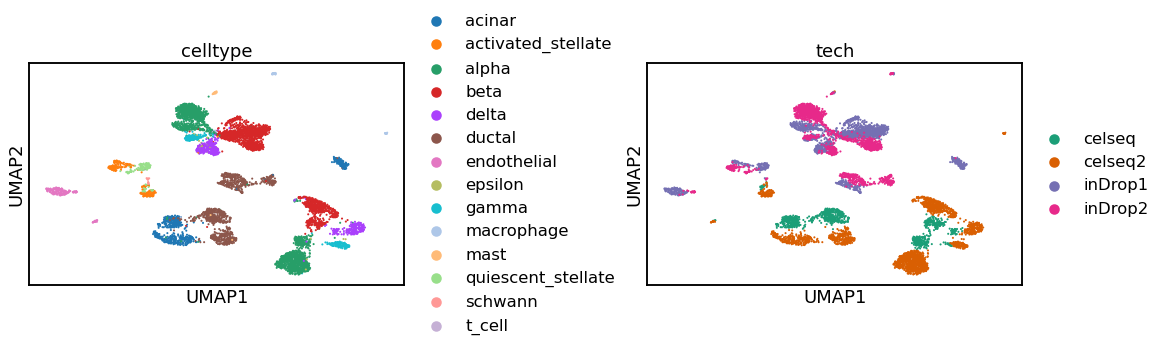

In [7]:
label_key = "celltype"
batch_key = "tech"
adata.uns["tech_colors"] = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a"] # Set custom colours for batches
sc.pl.umap(adata, color=[label_key, batch_key], wspace=0.5)

These plots clearly show that there are batch effects in this dataset. The two different technologies (cellseq and inDrop) are clearly separated and even for one technology there are differences between samples. If we consider the cell identity labels we see that cells which have the same label are not always located near each other. If we were to perform a clustering analysis using this raw data we would probably end up with different clusters for each sample/identity combination which would be difficult to interpret at the annotation stage. We are also likely to overlook rare cell types which are not common enough in any single sample to produce their own cluster.

Now that we have confirmed there are batch effects to correct we can move on to the different integration methods.

## Batch-aware feature selection

As shown in previous chapters we often select a subset of genes to use for our analysis in order to reduce noise and processing time. We do the same thing when we have multiple samples however, it is important that gene selection is performed in a batch-aware way. This is because genes that are variable across the whole dataset could be capturing batch effects rather than the biological signals we are interested in.

We can perform batch aware highly variable gene selection by setting the `batch_key` argument. **scanpy** will then calculate HVGs for each batch separately and combine the results by selecting those genes that are highly variable in the most batches.

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key)
adata
adata.var

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
A1BG,False,0.277454,2.866531,0.793526,1,False
A1CF,True,1.029200,2.514877,2.743373,3,False
A2M,True,0.150296,3.321352,3.592893,3,False
A2ML1,False,0.029536,1.173582,-0.009800,0,False
A4GALT,False,0.123540,2.816152,-0.453725,0,False
...,...,...,...,...,...,...
ZXDC,False,1.185176,2.242674,0.019727,0,False
ZYG11B,False,1.217888,2.152272,-0.331415,0,False
ZYX,False,1.046739,2.408431,1.389648,1,False
ZZEF1,False,0.810198,2.407011,-0.260825,0,False


We can see there are now some addtional columns in `var`:

* `highly_variable_nbatches` - The number of batches where each gene was found to be highly variable
* `highly_variable_intersection` - Whether each genes was highly variable in every batch
* `highly_variable` - Whether each genes was selected as highly variable after combining the results from each batch 

Let's check how many batches each gene was variable in:

0    14779
1     2284
2      922
3      560
4      548
Name: highly_variable_nbatches, dtype: int64

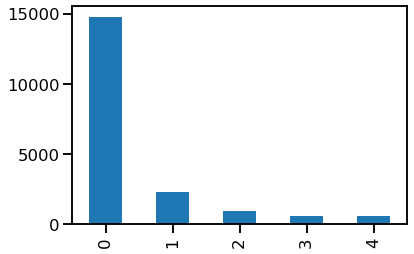

In [9]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

The first thing we notice is that most genes are not highly variable. This is typically the case but it can depend on how different the samples we are trying to integrate are. The overlap then decreases as we add more samples with relatively few genes being highly variable in all four batches. By selecting the top 2000 genes we have selected all HVGs that are present in three or four batches and most of those that are present in two batches.

> **How many genes to use?**
>
> This is a question which doesn't have a clear answer. The authors of the **scvi-tools** package which we use below recommend between 1000 and 10000 genes but how many depends on the context including the complexity of the dataset and the number of batches.
> In general it is better to select slightly too many genes than to select too few and risk removing genes which are important for a rare cell type.
> However, more genes will also increase the time required to run the integration methods.

We will create an object with just the selected genes to use for integration.

In [10]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'tech_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

## Integrating with scVI

The first integration method we will use is **scVI**, a method based on a conditional variational autoencoder. A [variational autoencoder](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) is a type of artificial neural network which attempts to reduce the dimensionality of a dataset and reconstruct its distribution. The conditional part refers to explicitly considering differences between conditions (in this case batches) during this process in order to remove their effects. In benchmarking studies **scVI** has been shown to perform well across a range of datasets with a good balance of batch correction while conserving biological variability [REF]. **scVI** models raw counts directly so it is important that we provide it with a counts matrix rather than a normalised expression matrix.

First let's make a copy of our dataset to use for this integration. Normally it is not necessary to do this but as we will demonstrate multiple integration methods making a copy makes it easier to show what has been added by each method.

In [20]:
adata_scvi = adata_hvg.copy()

### Data preparation

The first step in using **scVI** is prepare our AnnData object. This step stores some information required by **scVI** such as which expression matrix to use and what the batch key is.

In [21]:
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'tech_colors', 'celltype_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

The fields created by **scVI** are prefixed with `_scvi`. These are designed for internal use and should not be manually modified. The general advice from **scVI** is that we shoudl not to make any changes to our object until after the model is trained. Note the warning about `adata.layers["counts"]` containing unnormalised count data. In our case this is expected as some of our samples contain inferred counts (as mentioned above) but usually when you see this you should check that the layer provided to the setup function does actually contain count values.

In [23]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.15.5.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'tech',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 6950  │
│          n_vars          │ 2000  │
│         n_batch          │   4   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                  
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location  ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['tech'] │   celseq   │          0          │
│                   │  celseq2   │          1          │
│                   │  inDrop1   │          2          │
│                   │  inDrop2   │          3          │
└───────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

Here we can see the number of batches, the labels for those batches and how **scVI** has encoded them. It is important to check this information to double check everything is as intended.

### Building the model

We can now construct an **scVI** model object. As well as the **scVI** model we use here the **scvi-tools** package contains various other models (we will use the **scANVI** model below).

In [22]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

The model object contains the provided AnnData object as well as the neural network for the model itself. You can see that currently the model is not trained. If we wanted to modify the structure of the network we could provide additional arguments to the model construction function but here we just use the defaults.

We can also print a more detailed description of the model that show us where things are stored in the associated AnnData object.

### Training the model

The model will be trained for a given number of _epochs_ (a training iteration where every cell is passed through the network). The following code is a suggested heuristic for reducing the number of epochs for larger datasets. Because this dataset has less than 20000 cells it returns the default value of 400.

In [24]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

400

We now train the model for the selected number of epochs (this will take ~15-30 minutes depending on the computer you are using).

In [25]:
model_scvi.train(max_epochs=max_epochs_scvi)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|██████████| 400/400 [10:55<00:00,  1.64s/it, loss=983, v_num=1]   


> **Early stopping**
>
> An alternative to manually setting the number of epochs is to set `early_stopping=True` in the training function. This will let **scVI** decide to stop training early depending on the convergence of the model.
> The exact conditions for stopping can be controlled by other parameters.

## Extracting the embedding 

The main result we want to extract from the trained model is the latent representation for each cell. This is an embedding where the batch effects have been removed. We store this in `obsm` with the key `X_scvi`.

In [26]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

### Calculate corrected UMAP

We will now visualise the data as we did before integrated. We calculate a new UMAP embedding but instead of finding nearest neighbours in PCA space we start with the corrected representation from **scVI**.

In [27]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'tech_colors', 'celltype_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

Once we have the new UMAP representation we can plot it coloured by batch and identity labels as before.

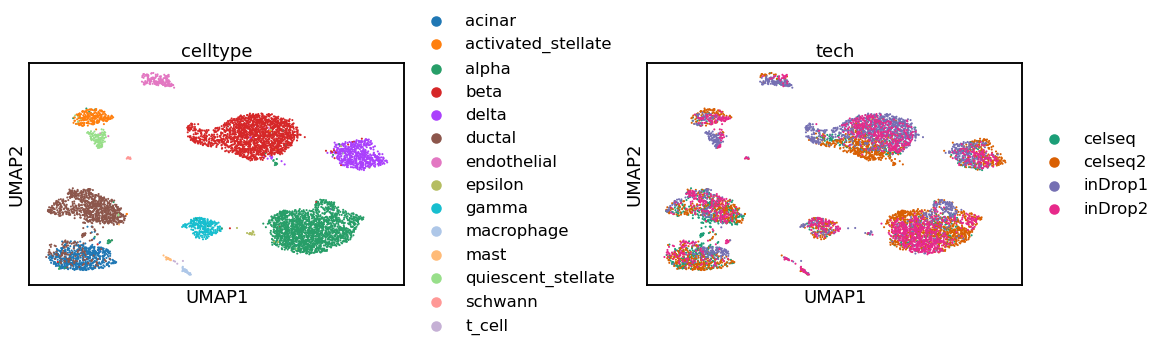

In [28]:
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=0.5)

This looks much better! Before, the various batches were separated and the same cell identity in different batches were far apart from each other. Now, the batches are all mixed with each other and we have a single blob for each cell identity label.

In many cases we would not already have identity labels so from this stage we would continue with clustering, annotation and further analysis as described in other sections.

## Integrating with scANVI

When performing integration with **scVI** we pretended that we didn't already have any cell labels (although we showed them in plots). While this scenario is common there are some cases where we do know something about cell identity in advance. Most often this is when we want to combine one or more publicly available datasets with data from a new study. When we have labels for at least some of the cells we can use **scANVI**. This is an extension of the **scVI** model that knows about cell labels as well as batches. Because it has this extra information it can try to keep the differences between cell labels while removing batch effects. Benchmarking suggests that **scANVI** tends to better preserve biological signals compared to **scVI** but sometimes it is not as effective at removing batch effects. While we have labels for all cells here it is also possible to use **scANVI** in a semi-supervised manner where labels are only provided for some cells.

> **Label harmonization**
>
> If you are using **scANVI** to integrate multiple datasets for which you already have labels it is important to first perform _label harmonization_.
> This refers to a process of checking that labels are consistent across the datasets that are being integrated.
> How best to do this is an open question but often requires input from subject-matter experts.

We start by creating a **scANVI** model object. Note that because **scANVI** refines an **scVI** model we provide that rather than an AnnData object. If we had not already trained an **scVI** model we would need to do that first. We also provide a key for the column of `adata.obs` which contains our cell labels as well as the label which corresponds to unlabelled cells. In this case all of our cells are labelled so we just provide a dummy value but in most cases it is important to check that this is set correctly so that **scANVI** knows which label to ignore. 

In [43]:
# Normally we would need to run scVI first but we have already done that here
# model_scvi = scvi.model.SCVI(adata_scvi) etc.
model_scanvi = scvi.model.SCANVI.from_scvi_model(model_scvi, labels_key=label_key, unlabeled_category="unlabelled")
print(model_scanvi)
model_scanvi.view_anndata_setup()

ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, 
dispersion: gene, gene_likelihood: zinb
Training status: Not Trained

Anndata setup with scvi-tools version 0.15.5.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'celltype',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'counts',
│   'batch_key': 'tech',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 6950  │
│          n_vars          │ 2000  │
│         n_batch          │   4   │
│         n_labels         │  15   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                  
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location  ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['tech'] │   celseq   │          0          │
│                   │  celseq2   │          1          │
│                   │  inDrop1   │          2          │
│                   │  inDrop2   │          3          │
└───────────────────┴────────────┴─────────────────────┘

                       labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │       acinar       │          0          │
│                       │ activated_stellate │          1          │
│                       │       alpha        │          2          │
│                       │        beta        │          3          │
│                       │       delta        │          4          │
│                       │       ductal       │          5          │
│                       │    endothelial     │          6          │
│                       │      epsilon       │          7          │
│                       │       gamma        │          8          │
│                       │     macrophage     │          9          │
│                       │        mast        │         10          │
│                       │ quiescent_stellate │         11          │
│                       │      schwann       │         12          │
│                       │       t_cell       │         13          │
│                       │     unlabelled     │         14          │
└───────────────────────┴────────────────────┴─────────────────────┘

This model object is very similar to what we saw before for **scVI**. As mentioned previously we could modify the structure of the model network but here we just use the default.

Again we have a heuristic for selecting the number of training epochs. Note that this is much fewer than before as we are just refining the **scVI** model, rather than training a whole network from scratch.

In [44]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scanvi)

INFO     Training for 10 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/10: 100%|██████████| 10/10 [00:25<00:00,  2.50s/it, loss=1.07e+03, v_num=1]


We can extract the new latent representation from the model and create a new UMAP embedding as we did for **scVI**.

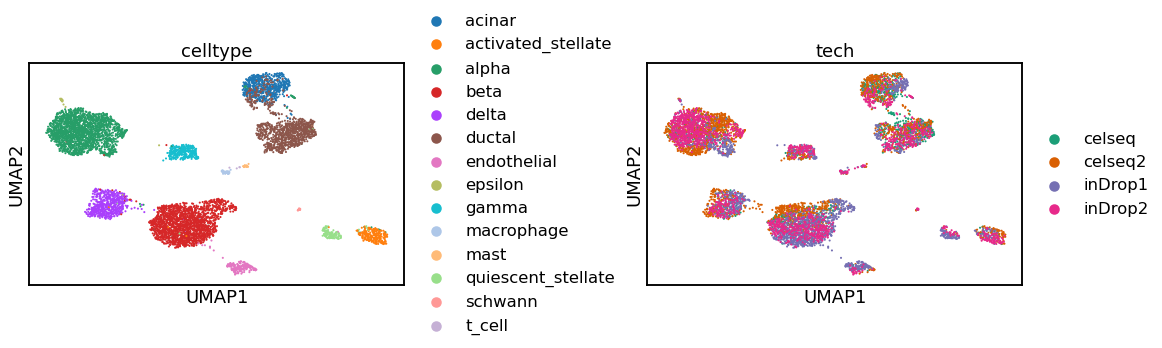

In [46]:
adata_scanvi = adata_scvi.copy()
adata_scanvi.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scanvi, use_rep="X_scANVI")
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=[label_key, batch_key], wspace=0.5)

By looking at the UMAP representation it is difficult to tell the difference between **scANVI** and **scVI** but when the effect of the refinement has been quantified it has been shown to often better preserve biological variation.

## BBKNN

The next method we will look at is **BBKNN** or "Batch Balanced KNN". This is a very different approach to **scVI**, rather than using a neural network to embed cells in a batch-corrected space it instead modifies how the KNN graph used for clustering and embedding is constructed. As we have seen in previous chapters the normal KNN procedure connects cells to the most similar cells across the whole dataset. The change that **BBKNN** makes is to enforce that cells are connected to cells from other batches. While this is a simple modification it can be quite effective, particularly when there are very strong batch effects. However, as the result is an integrated graph it can have limited downstream uses as few packages will accept this as an input.

An important parameter for **BBKNN** is the number of neighbours per batch. A suggested heuristic for this is to use 25 if there are less than 10000 cells or the default of 3 if there are more than 10000.

In [58]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 10000 else 3

Before using **BBKNN** we first perform a PCA as we would before building a normal KNN graph. Unlike **scVI** which models raw counts here we start with the log-normalised expression matrix.

In [59]:
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"]
sc.pp.pca(adata_bbknn)

We can now run **BBKNN**, replacing the call to the **scanpy** `neighbors()` function in a standard workflow. An important difference is to make sure the `batch_key` argument is set which specifies a column in `adata_hvg.obs` which contains batch labels.

In [60]:
bbknn.bbknn(adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch)
adata_bbknn

AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'tech_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

Unlike the default **scanpy** function **BBKNN** does not allow specifying a key for storing results so they are always stored under the default "neighours" key.

We can use this new integrated graph just like we would a normal KNN graph to construct a UMAP embedding.

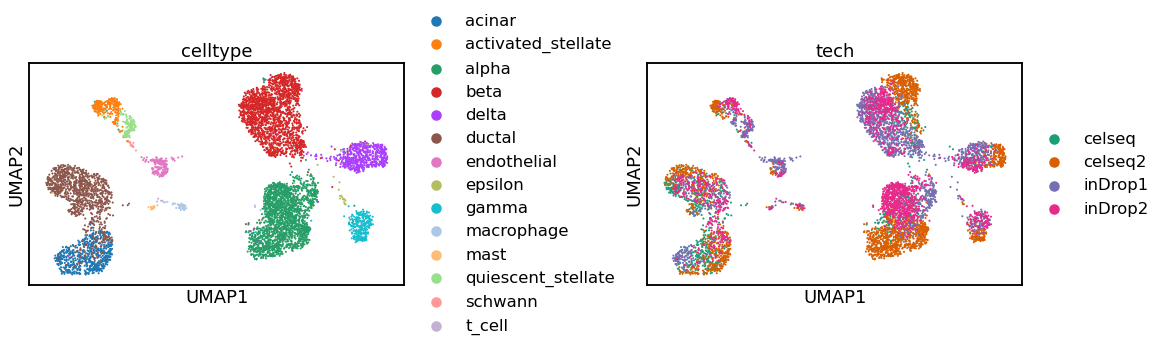

In [61]:
sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color=[label_key, batch_key], wspace=0.5)

This integration is also much improved compared to the unintegrated data with cell identities grouped together and batches clearly mixed.

## ComBat

Some downstream applications cannot accept an integrated embedding or neighbourhood graph and require a corrected expression matrix. One method that can produce this output is **ComBat**. This is an old method originally designed for microarray data that uses an empirical Bayes approach to centre and scale the expression matrix. While this is not usually among the best methods in benchmarking studies it has the advantages of being very quick to run, easier to interpret (due to a linear correction) and producing a corrected expression matrix.

There are several implementations of **ComBat** available, here we use the one in **scanpy**. Using **ComBat** is very simple, we just supply an AnnData object and a key specifying the batch variable to remove. Note that **ComBat** expects log-normalised data as input (there is a newer variant which operates directly on counts called **ComBat-seq** but we don't show that here). Once we have the corrected expression matrix we store it as a new layer called "combat".

In [62]:
adata_combat = adata_hvg.copy()
adata_combat.X = adata_combat.layers["logcounts"]
sc.pp.combat(adata_combat, key=batch_key, inplace=True)
adata_combat.layers["combat"] = adata_combat.X
adata_combat

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'tech_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'combat'
    obsp: 'distances', 'connectivities'

The corrected expression matrix can then be analysed as normal, except that now the batch effects should be removed. Let's make a UMAP as we have done for the other methods.

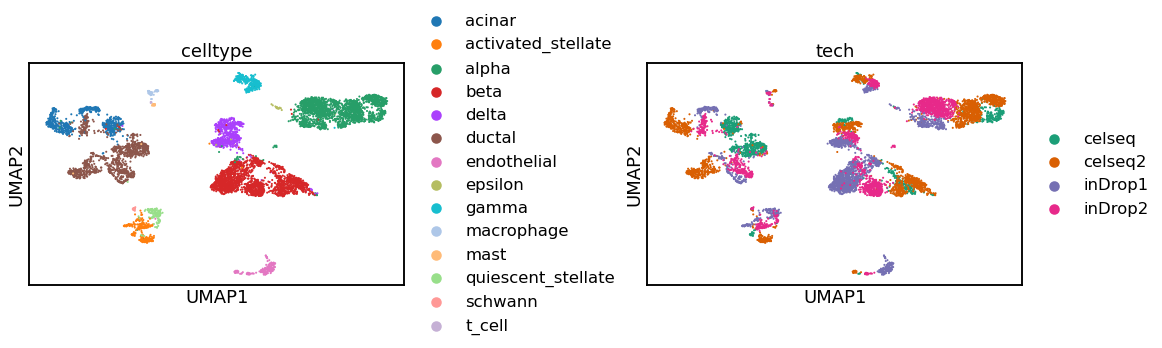

In [63]:
sc.pp.pca(adata_combat)
sc.pp.neighbors(adata_combat)
sc.tl.umap(adata_combat)
sc.pl.umap(adata_combat, color=[label_key, batch_key], wspace=0.5)

While the cell labels are now better grouped the mixing between batches is not as complete as we have seen with other methods. However, while looking at a UMAP can tell you if there are very clear batch effects it is not the best way to evaluate an integration and it is important not to over interpret it. In the next section we present some approaches to more rigorously evaluate integration methods.

## Benchmarking your own integration

The methods demonstrated here are based on results from benchmarking experiments including the single-cell integration benchmarking project. This project also produced a software package called **scib** that can be used to run a range of integration methods as well as the metrics that were used for evaluation. In this section we show how to use this package to evaluate the quality of an integration.

> **What is the ground truth?**
>
> Some of these metrics, particularly those that evaluate conservation of biological variation, require a known ground truth to compare to. Usually this is a cell identity label but can sometimes be other information such as known trajectories. Because of this requirement it is difficult to evaluate integration for a completely new dataset where it is unclear what biological signal should be preserved.

The **scib** metrics can be run individually but there are also wrappers for running multiple metrics at once. Here we run a subset of the metrics which are quick to compute using the `metrics_fast()` function. This function takes a few arguments: the original unintegrated dataset, the integrated dataset, a batch key and a label key. Depending on the output of the integration method we might also need to supply additional arguments, for example here we specify the embedding to use for **scVI** and **scANVI** with the `embed` argument. You can also control how some metrics are run with additional arguments.

Let's run the metrics for each of the integrations we have performed above, as well as the unintegrated data.

In [64]:
metrics_scvi = scib.metrics.metrics_fast(adata, adata_scvi, batch_key, label_key, embed="X_scVI")
metrics_scanvi = scib.metrics.metrics_fast(adata, adata_scanvi, batch_key, label_key, embed="X_scANVI")
metrics_bbknn = scib.metrics.metrics_fast(adata, adata_bbknn, batch_key, label_key)
metrics_combat = scib.metrics.metrics_fast(adata, adata_combat, batch_key, label_key)
metrics_hvg = scib.metrics.metrics_fast(adata, adata_hvg, batch_key, label_key)

Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...


Here is an example of what one of the metrics results looks like for a single integration:

In [65]:
metrics_hvg

,0
NMI_cluster/label,NaN
ARI_cluster/label,NaN
ASW_label,0.557769
ASW_label/batch,0.825674
PCR_batch,0.630677
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.460290
graph_conn,0.936387
kBET,NaN


Each row is a different metric and the values show the score for each metrics. Scores are between 0 and 1, where 1 is a good performance and 0 is a poor performance. Because we have only run the fast metrics here some of the metrics have `NaN` scores. Also note that some metrics cannot be used with some output formats which can also be a reason for `NaN` values being returned.

To compare the methods it is useful to have the metrics results in one table. This code combines them and tidies them into a more convenient format.

In [66]:
# Concatenate metrics results
metrics = pd.concat([metrics_scvi, metrics_scanvi, metrics_bbknn, metrics_combat, metrics_hvg], axis="columns")
# Set methods as column names
metrics = metrics.set_axis(["scVI", "scANVI", "BBKNN", "ComBat", "Unintegrated"], axis="columns")
# Set only the fast metrics
metrics = metrics.loc[["ASW_label", "ASW_label/batch", "PCR_batch", "isolated_label_silhouette", "graph_conn", "hvg_overlap"], :]
# Transpose so that metrics are columns and methods are rows
metrics = metrics.T
metrics

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap
scVI,0.632350,0.870560,0.941113,0.650758,0.987174,1.000000
scANVI,0.649168,0.871655,0.931842,0.643882,0.986529,1.000000
BBKNN,0.593148,0.822940,0.630677,0.482258,0.976616,1.000000
ComBat,0.608349,0.851191,0.999988,0.498727,0.984112,0.666138
Unintegrated,0.557769,0.825674,0.630677,0.460290,0.936387,1.000000


We now have all the scores in one table with metrics as columns and methods as rows. Styling the table with a gradient can make it easier to see the differences between scores.

In [67]:
metrics.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap
scVI,0.632350,0.870560,0.941113,0.650758,0.987174,1.000000
scANVI,0.649168,0.871655,0.931842,0.643882,0.986529,1.000000
BBKNN,0.593148,0.822940,0.630677,0.482258,0.976616,1.000000
ComBat,0.608349,0.851191,0.999988,0.498727,0.984112,0.666138
Unintegrated,0.557769,0.825674,0.630677,0.460290,0.936387,1.000000


For some metrics the scores tend to be in a relatively small range. To emphasise the differences between methods and place each metric on the same scale we scale them so that the worst performer gets a score of 0, the best performer gets a score of 1 and the others are somewhere in between.

In [68]:
metrics_scaled = (metrics - metrics.min()) / (metrics.max() - metrics.min())
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap
scVI,0.815995,0.977517,0.840580,1.000000,1.000000,1.000000
scANVI,1.000000,1.000000,0.815476,0.963901,0.987311,1.000000
BBKNN,0.387083,0.000000,0.000000,0.115337,0.792124,1.000000
ComBat,0.553398,0.579921,1.000000,0.201808,0.939718,0.000000
Unintegrated,0.000000,0.056128,0.000000,0.000000,0.000000,1.000000


The values now better represent the differences between methods (and better match the colour scale). However it is important to note that the scaled scores can only be used to compare the relative performance of this specific set of integrations. If we wanted to add another method we would need to perform the scaling again. We also can't say that an integration is definitively "good", only that it is better than the other methods we have tried. This scaling emphasises differences between methods. For example, if we had metric scores of 0.92, 0.94 and 0.96 these would be scaled to 0, 0.5 and 1.0. This makes the first method appear to score much worse, even though it is only slightly lower than the other two and still got a very high score. This effect is bigger when you are comparing few methods and when they get similar raw scores. Whether you look at raw or scaled scores depends on whether you want to focus on absolute performance or difference in performance between methods.

The evaluation metrics can be grouped into two categories, those that measure the removal of batch effects and those that measure the conservation of biological variation. We can calculate summary scores for each of these categories by taking the mean of the scaled values for each group. This kind of summary score wouldn't make sense with raw values as some metrics consistently produce higher scores than others.

In [69]:
metrics_scaled["Batch"] = metrics_scaled[["ASW_label/batch", "PCR_batch", "graph_conn"]].mean(axis=1)
metrics_scaled["Bio"] = metrics_scaled[["ASW_label", "isolated_label_silhouette", "hvg_overlap"]].mean(axis=1)
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap,Batch,Bio
scVI,0.815995,0.977517,0.840580,1.000000,1.000000,1.000000,0.939366,0.938665
scANVI,1.000000,1.000000,0.815476,0.963901,0.987311,1.000000,0.934262,0.987967
BBKNN,0.387083,0.000000,0.000000,0.115337,0.792124,1.000000,0.264041,0.500807
ComBat,0.553398,0.579921,1.000000,0.201808,0.939718,0.000000,0.839880,0.251735
Unintegrated,0.000000,0.056128,0.000000,0.000000,0.000000,1.000000,0.018709,0.333333


Plotting the two summary scores against each other gives an indication of the priorities of each method, some will be biased towards batch correction while others will favour retaining biological variation.

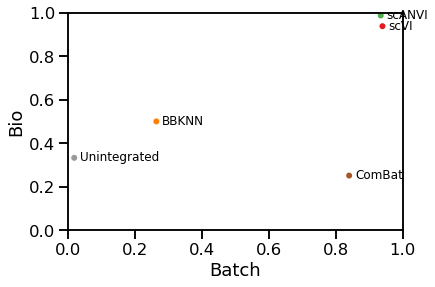

In [70]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
metrics_scaled.plot.scatter(
    x="Batch",
    y="Bio",
    c=range(len(metrics_scaled)),
    colormap=matplotlib.cm.get_cmap("Set1"),
    ax=ax
)

for k, v in metrics_scaled[["Batch", "Bio"]].iterrows():
    ax.annotate(
        k, v,
        xytext=(6, -3),
        textcoords="offset points",
        family="sans-serif",
        fontsize=12
    )

In our small example scenario it looks as though **BBKNN** has removed less of the batch effects but retained more biological variation while **ComBat** has removed more batch effects but also removed biological variation. Both **scVI** and **scANVI** perform well on both categories, with **scANVI** being slightly better at retaining biological variation.

To get an overall score for each method we can combine the two summary scores. The **scIB** paper suggests a weighting of 40% batch correction and 60% biological conservation but you may prefer to weight things differently depending on the priorities for your dataset.

In [71]:
metrics_scaled["Overall"] = 0.4 * metrics_scaled["Batch"] + 0.6 * metrics_scaled["Bio"]
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap,Batch,Bio,Overall
scVI,0.815995,0.977517,0.840580,1.000000,1.000000,1.000000,0.939366,0.938665,0.938945
scANVI,1.000000,1.000000,0.815476,0.963901,0.987311,1.000000,0.934262,0.987967,0.966485
BBKNN,0.387083,0.000000,0.000000,0.115337,0.792124,1.000000,0.264041,0.500807,0.406101
ComBat,0.553398,0.579921,1.000000,0.201808,0.939718,0.000000,0.839880,0.251735,0.486993
Unintegrated,0.000000,0.056128,0.000000,0.000000,0.000000,1.000000,0.018709,0.333333,0.207484


Let's make a quick bar chart to visualise the overall performance.

<AxesSubplot:>

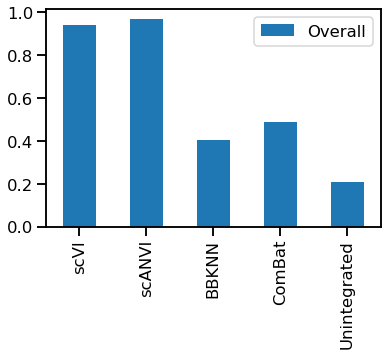

In [72]:
metrics_scaled.plot.bar(y = "Overall")

As we have already seen **scVI** and **scANVI** are the best performers with **scANVI** scoring slightly higher.

Existing benchmarks have suggested methods which generally perform well but performance can also be quite variable across scenarios. For some analyses it may be worthwhile performing your own evaluation of integration. The **scib** package makes this process easier but it can still be a significant undertaking, relying on a good knowledge of the ground truth and interpretation of the metrics.

## Session information

In [74]:
import session_info

session_info.show()

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/jupyterlab_server/app.py:31: DeprecationWarning: metadata {'default': '2.8.2'} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  app_version = Unicode('', help='The version of the application.',
/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)
